In [113]:
from utils import get_db_engine
import pandas as pd

# p_date, cluster, count(distinct match_id) as match_count

# T10：where p_date >= '20210919' and p_date <= '20211120'
# w_ti_end_date = "20211017"


battle_df = pd.read_sql("""
    select 
        p_date, cluster, count(match_id) as match_count
    from all_dota2_match
    where p_date >= '20210919' and p_date <= '20211120'
    group by p_date, cluster
""", get_db_engine("dota2"))

battle_df.head(3)

,p_date,cluster,match_count
0,20190827,138,13213
1,20190826,135,15655
2,20190904,236,29578


In [114]:
cluster_to_region_dict = {
    1: 'Unknown',
    227: 'China',
    192: 'Europe East',
    193: 'Europe East',
    201: 'South America',
    202: 'South America',
    203: 'South America',
    213: 'South Africa',
    214: 'South Africa',
    223: 'China',
    225: 'China',
    231: 'China',
    188: 'Russia',
    232: 'China',
    236: 'China',
    241: 'Chile',
    251: 'Peru',
    261: 'India',
    271: 'Europe',
    273: 'Europe',
    274: 'Europe',
    346: 'Unknown',
    191: 'Europe East',
    187: 'Russia',
    117: 'US West',
    154: 'SE Asia',
    118: 'US West',
    121: 'US East',
    122: 'US East',
    123: 'US East',
    144: 'South Korea',
    145: 'South Korea',
    151: 'SE Asia',
    152: 'SE Asia',
    153: 'SE Asia',
    155: 'SE Asia',
    186: 'Russia',
    156: 'SE Asia',
    161: 'Dubai',
    171: 'Australia',
    172: 'Australia',
    181: 'Russia',
    182: 'Russia',
    183: 'Russia',
    184: 'Russia',
    185: 'Russia',
    347: 'Unknown'
}

battle_df["region"]  = battle_df["cluster"].apply(lambda x: cluster_to_region_dict[x] if x in cluster_to_region_dict else "None")
battle_df.head(3)

,p_date,cluster,match_count,region
0,20190827,138,13213,None
1,20190826,135,15655,None
2,20190904,236,29578,China


In [120]:
## 只考虑对局数TOP 8的地区（太小的地区，数据波动可能较大）

battle_df_back = battle_df.copy()
battle_df = battle_df[battle_df["region"].isin(battle_df.groupby("region").agg(sum_match_count = ("match_count", "sum")).reset_index().sort_values("sum_match_count", ascending = False).head(8)["region"].tolist())]
battle_df

,p_date,cluster,match_count,region
0,20190827,138,13213,None
1,20190826,135,15655,None
2,20190904,236,29578,China
3,20190826,191,16058,Europe East
5,20190827,236,36295,China
...,...,...,...,...
1061,20190829,152,31924,SE Asia
1062,20190822,231,10433,China
1064,20190825,137,13709,None
1065,20190818,182,26041,Russia


### 国服对局数，TI10前后对比

上升了？ 但会不会TI后本来就要上升，其他地区都在上升？

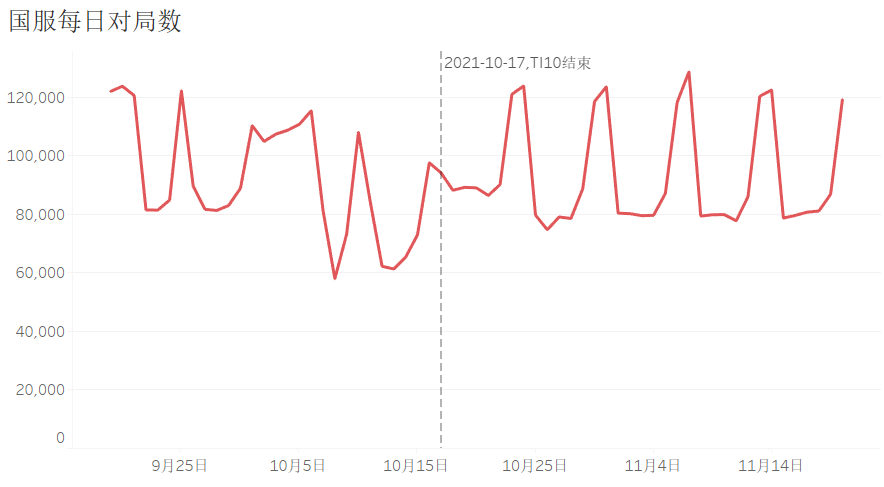

In [77]:
# w_region = "China"
# w_region = "Russia"
# w_region = "SE Asia"

w_region = "synthetic_China"

# w_df = battle_df
w_df = pd.concat([battle_df_back, synthetic_df])


w_df = w_df[w_df["region"] == w_region].groupby("p_date").agg(match_count = ("match_count", "sum")).reset_index().sort_values("p_date").copy()

import datetime

before_begin_date =  datetime.datetime.strftime(datetime.datetime.strptime(w_ti_end_date, "%Y%m%d") + datetime.timedelta(days=-28), "%Y%m%d")
after_end_date = datetime.datetime.strftime(datetime.datetime.strptime(w_ti_end_date, "%Y%m%d") + datetime.timedelta(days=+28), "%Y%m%d")

before_avg_match_count = w_df[(w_df["p_date"] >= before_begin_date) & (w_df["p_date"] < w_ti_end_date)]["match_count"].mean()
after_avg_match_count = w_df[(w_df["p_date"] > w_ti_end_date) & (w_df["p_date"] <= after_end_date)]["match_count"].mean()

print(f"{w_region}——TI10前4周日均对局数：{before_avg_match_count:.0f}, TI10后4周日均对局数：{after_avg_match_count:.0f}(环比{(after_avg_match_count - before_avg_match_count) / before_avg_match_count:+.2%})")

synthetic_China——TI10前4周日均对局数：92411, TI10后4周日均对局数：126234(环比+36.60%)


## DID：国服 vs 其他单个region的数据

如何找benchmark？
1. 找俄罗斯，显然不太好
2. 找东南亚？好像比较合适


然后国服和东南亚比（我们认为东南亚的情绪波动，没有我们大。淘汰的比我们早）


It is saying that in the case of no intervention, the outcome in the latter period would be the same as the outcome from the starting period. 

### 国服 vs 俄罗斯

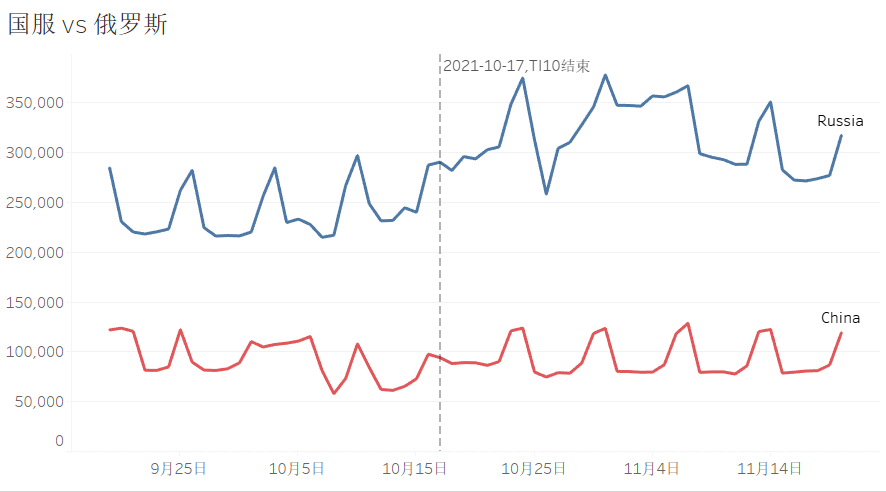

### 国服 vs 东南亚

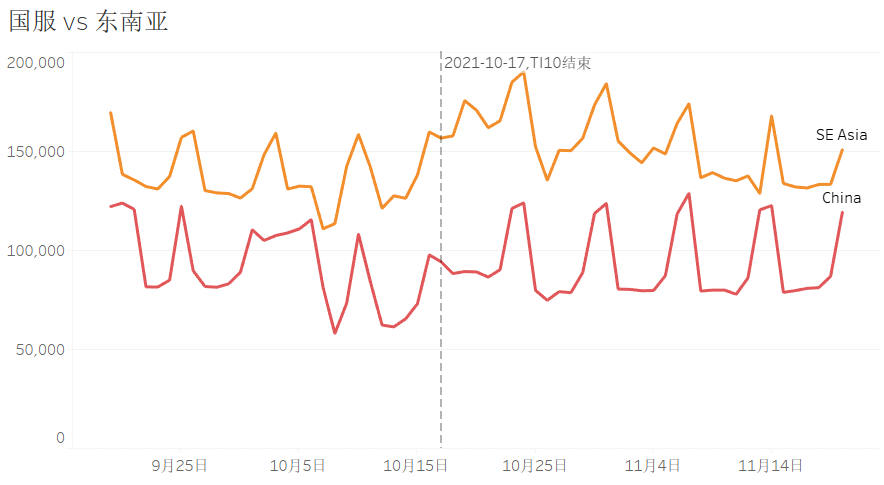

DID，后三周 - 前三周。 把东南亚作为参照（benchmark）来考虑。 计算

In [79]:
SE_Asia_before, SE_Asia_after = 137431, 156268
China_before, China_after = 92278, 93986

synthetic_China_before, synthetic_China_after = 92411, 126234

# print(SE_Asia_before, SE_Asia_after, China_before, China_after)
# diff_in_diff = (China_after - China_before) - (SE_Asia_after - SE_Asia_before)
# diff_in_diff

print(synthetic_China_before, synthetic_China_after, China_before, China_after)
diff_in_diff = (China_after - China_before) - (synthetic_China_after - synthetic_China_before)

diff_in_diff,  diff_in_diff / China_before

92411 126234 92278 93986


(-32115, -0.34802444786406295)

### 有没有更靠谱的参照？ —— 合成控制法

虚拟出一个，在之前完全，给我来3%的俄罗斯，2，精心拼凑出一个在比赛和国服趋势完全相近的“地区”。

We will combine the other states to build a fake state that resembles very closely the trend of California.


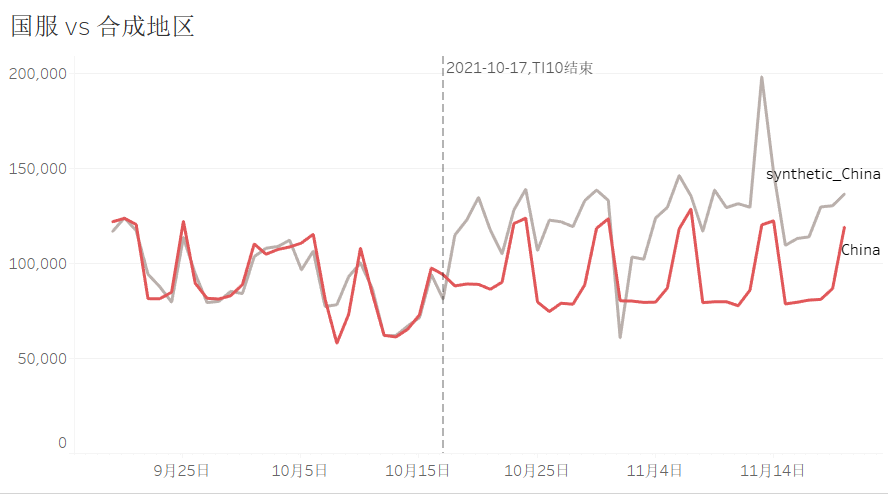

In [121]:
region_df = battle_df[battle_df["region"] != "Unknown"].groupby(["p_date", "region"]).agg(match_count = ("match_count", "sum")).reset_index()
# region_df = battle_df.groupby(["p_date", "region"]).agg(match_count = ("match_count", "sum")).reset_index()
region_df.head(3)

inverted = region_df[region_df["p_date"] < w_ti_end_date].pivot(index = "region", columns = "p_date")["match_count"].T
inverted.head(3)

region,China,Europe East,None,...,SE Asia,South Korea,US East
p_date,,,,,,,
20190816,127128,35821,111587,...,166834,38077,29642
20190817,173168,38320,121682,...,204189,37297,31549
20190818,198535,42849,133988,...,218693,37973,35834


In [38]:
inverted.columns

Index(['Australia', 'Chile', 'China', 'Dubai', 'Europe', 'Europe East',
       'India', 'Peru', 'Russia', 'SE Asia', 'South Africa', 'South America',
       'South Korea', 'US East', 'US West'],
      dtype='object', name='region')

['-4.78', '1.26', '-2.64', '-0.37', '1.45', '0.48', '3.42']


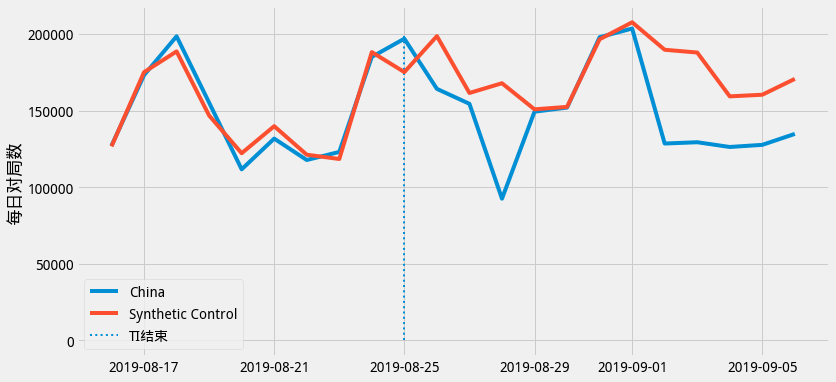

['0.01', '0.45', '0.09', '0.03', '-0.04', '-0.14', '-0.45']


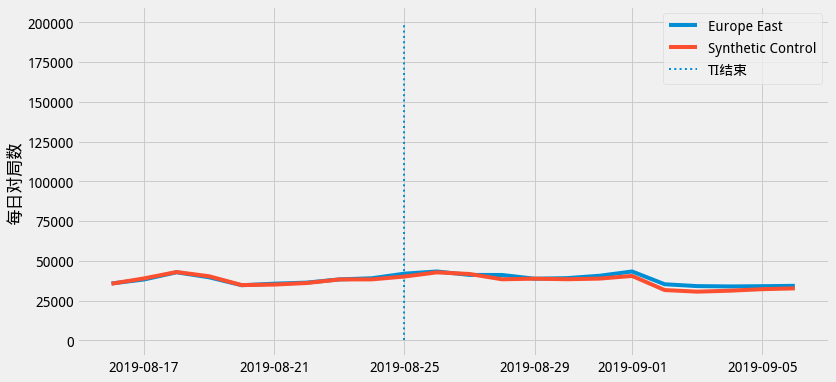

['0.14', '2.73', '0.36', '-0.00', '-0.17', '0.11', '0.00']


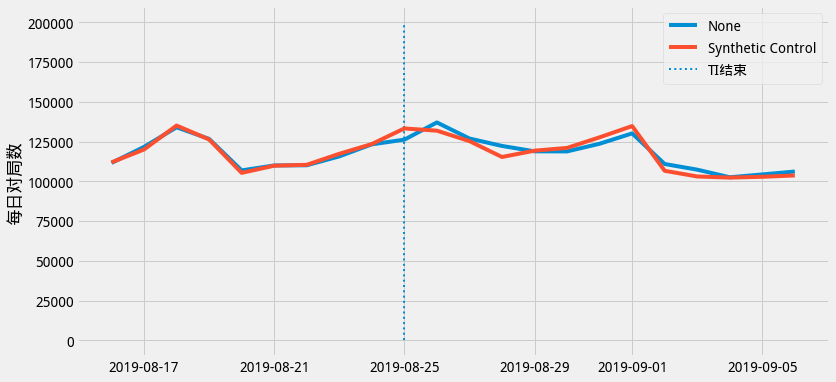

['-0.03', '0.76', '0.05', '0.04', '-0.01', '0.17', '0.44']


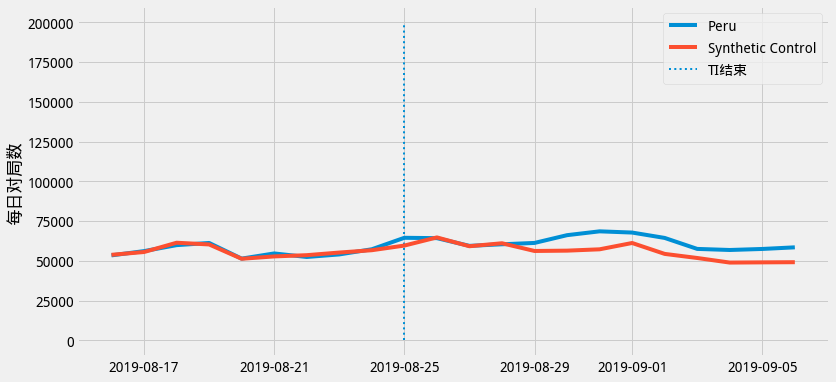

['0.05', '4.87', '-0.05', '1.05', '-0.14', '-0.16', '-0.95']


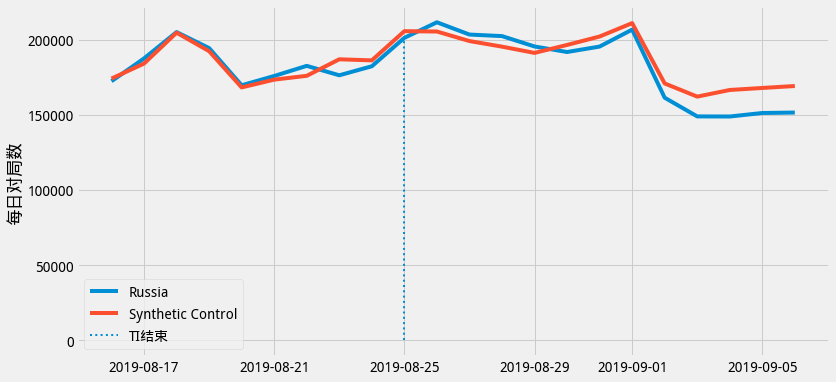

['0.55', '3.54', '-0.12', '1.50', '-0.00', '-0.22', '-2.85']


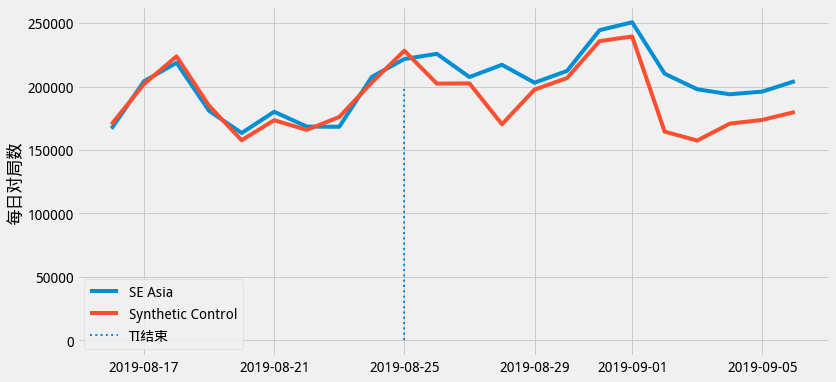

['0.10', '1.06', '0.09', '0.58', '-0.10', '-0.06', '-1.15']


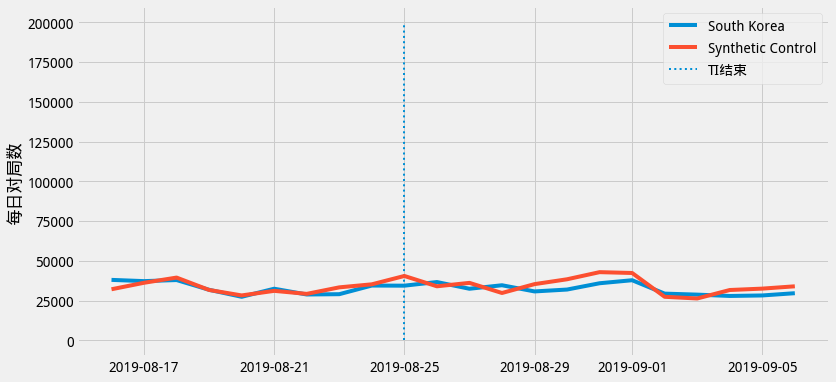

['0.09', '0.84', '0.06', '0.50', '-0.08', '-0.14', '-0.21']


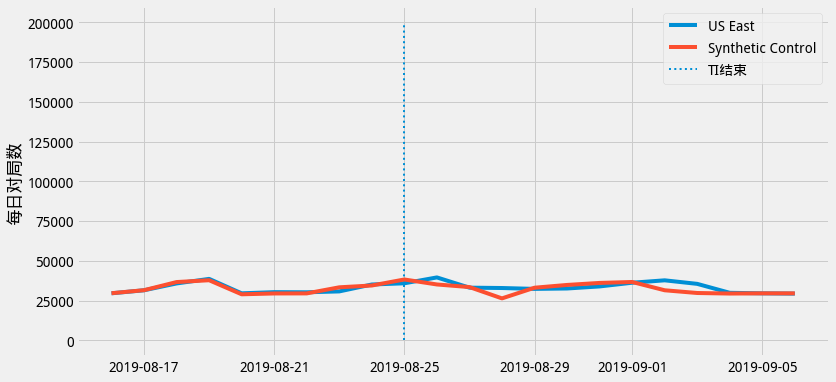

In [122]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# w_region = "Russia"
# w_region = "China"
# w_region = "SE Asia"
# w_region = "Australia"



for w_region in region_df["region"].unique():
#     if w_region != "SE Asia":
#     if w_region != "China":
#         continue

    y = inverted[w_region].values
    X = inverted.drop(columns=w_region).values
#     print(y, X)
#     weights = LinearRegression(fit_intercept=False).fit(X, y).coef_
#     weights = Ridge(fit_intercept=False).fit(X, y).coef_
#     weights = Lasso(fit_intercept=False).fit(X, y).coef_

#     weights = Lasso(fit_intercept=False, tol  = 100, positive = True).fit(X, y).coef_

#     weights = Lasso(fit_intercept=False, tol  = 1).fit(X, y).coef_
#     weights = Lasso(fit_intercept=False, tol  = 100).fit(X, y).coef_
    weights = Lasso(fit_intercept=False).fit(X, y).coef_

#     weights = Ridge(fit_intercept=False).fit(X, y).coef_
    print([f"{w:.2f}" for w in weights])

    synthetic_region = region_df[region_df["region"] != w_region].pivot(index='p_date', columns="region")["match_count"].values.dot(weights)
    
    import warnings
    warnings.filterwarnings('ignore')

    import pandas as pd
    import numpy as np
    from matplotlib import style
    from matplotlib import pyplot as plt
    import seaborn as sns
    import statsmodels.formula.api as smf
    from datetime import datetime

    %matplotlib inline

    pd.set_option("display.max_columns", 6)
    style.use("fivethirtyeight")

    show_region_df = region_df.copy()
    show_region_df['date'] = pd.to_datetime(show_region_df['p_date'], format='%Y%m%d')

    plt.figure(figsize=(12,6))
    plt.plot(show_region_df[show_region_df["region"] == w_region]["date"], show_region_df[show_region_df["region"] == w_region]["match_count"], label=w_region)
    plt.plot(show_region_df[show_region_df["region"] == w_region]["date"], synthetic_region, label="Synthetic Control")
    plt.vlines(x=datetime.strptime(w_ti_end_date, "%Y%m%d"), ymin=40, ymax=200000, linestyle=":", lw=2, label="TI结束")
    plt.ylabel("每日对局数")
    plt.legend();
    plt.show()
    

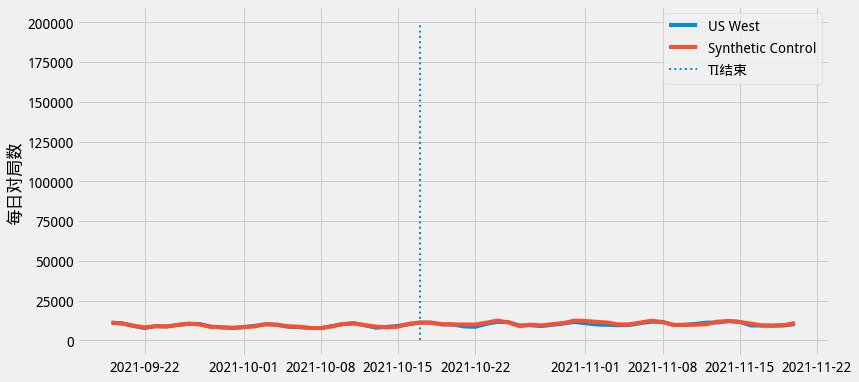

In [81]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from datetime import datetime

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

show_region_df = region_df.copy()
show_region_df['date'] = pd.to_datetime(show_region_df['p_date'], format='%Y%m%d')

plt.figure(figsize=(12,6))
plt.plot(show_region_df[show_region_df["region"] == w_region]["date"], show_region_df[show_region_df["region"] == w_region]["match_count"], label=w_region)
plt.plot(show_region_df[show_region_df["region"] == w_region]["date"], synthetic_region, label="Synthetic Control")
plt.vlines(x=datetime.strptime(w_ti_end_date, "%Y%m%d"), ymin=40, ymax=200000, linestyle=":", lw=2, label="TI结束")
plt.ylabel("每日对局数")
plt.legend();

In [75]:
w_region = "China"
synthetic_df = pd.DataFrame(synthetic_region, columns = ["match_count"])
synthetic_df["cluster"] = None
synthetic_df["region"] = f"synthetic_{w_region}"
synthetic_df["p_date"] = sorted(list(set(battle_df["p_date"].tolist())))
synthetic_df.head(3)

### 能不能进一步增加可靠性？ —— 把所有地区当成实验组，都来试一次

俄罗斯大涨，其他微涨，国服在暴跌

In [123]:
from typing import List
from operator import add
from toolz import reduce, partial


def synthetic_control(w_region: str, df: pd.DataFrame) -> np.array:    
    inverted = region_df[region_df["p_date"] < w_ti_end_date].pivot(index = "region", columns = "p_date")["match_count"].T
    y = inverted[w_region].values # state of california
    X = inverted.drop(columns=w_region).values  # other states
#     weights = LinearRegression(fit_intercept=False).fit(X, y).coef_
#     weights = Lasso(fit_intercept=False).fit(X, y).coef_
#     weights = Lasso(fit_intercept=False, positive=True).fit(X, y).coef_
#     weights = Lasso(fit_intercept=False, tol  = 0.001).fit(X, y).coef_
    weights = Lasso(fit_intercept=False).fit(X, y).coef_
    synthetic = region_df[region_df["region"] != w_region].pivot(index='p_date', columns="region")["match_count"].values.dot(weights)
    r_df = df[df["region"] == w_region].copy()
    r_df["synthetic"] = synthetic
    return r_df

w_region = "China"
w_df = synthetic_control(w_region, region_df)
w_df

,p_date,region,match_count,synthetic
0,20190816,China,127128,126677.856628
8,20190817,China,173168,175106.864788
16,20190818,China,198535,188669.026532
24,20190819,China,155245,146839.147476
32,20190820,China,111702,122219.577834
40,20190821,China,131764,139874.282132
48,20190822,China,117792,121244.694857
56,20190823,China,123052,118455.658319
64,20190824,China,185087,188226.969198
72,20190825,China,196966,175174.627551


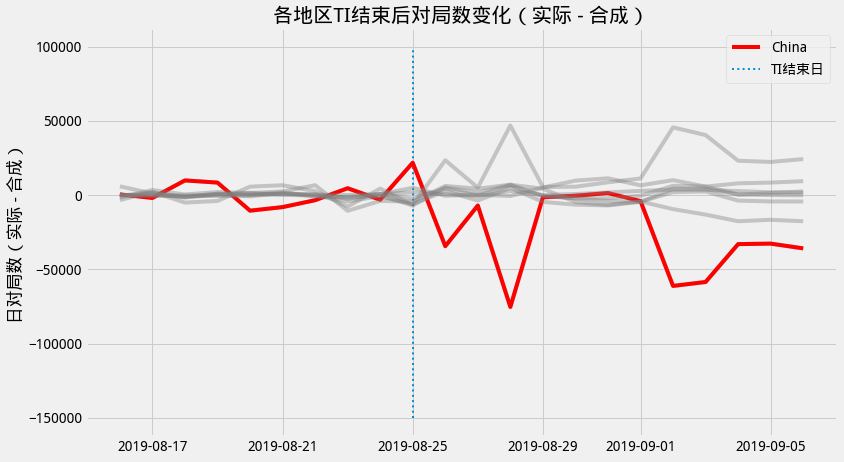

In [124]:
from joblib import Parallel, delayed

control_pool = region_df["region"].unique()
parallel_fn = delayed(partial(synthetic_control, df=region_df))
synthetic_regions = Parallel(n_jobs=4)(parallel_fn(w_region) for w_region in control_pool)

plt.figure(figsize=(12,7))
for region in synthetic_regions:
    region['date'] = pd.to_datetime(region['p_date'], format='%Y%m%d')
    plt.plot(region["date"], region["match_count"] - region["synthetic"], color="gray",alpha=0.4)
    if region["region"].iloc[0] == "China":
        plt.plot(region["date"], region["match_count"] - region["synthetic"], color="red", label = "China")
#     if region["region"].iloc[0] == "Russia":
#         plt.plot(region["date"], region["match_count"] - region["synthetic"], color="blue", label = "Russia")

plt.vlines(x=datetime.strptime(w_ti_end_date, "%Y%m%d"), ymin=-150000, ymax=100000, linestyle=":", lw=2, label="TI结束日")
# plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("日对局数（实际 - 合成）")
plt.title("各地区TI结束后对局数变化（实际 - 合成）")
plt.legend();

In [125]:
r_df = pd.concat(synthetic_regions)
r_df["diff"]  = r_df["match_count"] - r_df["synthetic"]